In [1]:
from annoy import AnnoyIndex
from create_index import create_index
import torch
from sentence_transformers import SentenceTransformer,util
from intellidiff import IntelliDiff
import re
import numpy as np
from vectorize import load_json, save_json,vectorize,generate_sim_matrix
from pullDescriptions import getDesc
import scipy.cluster.hierarchy as hc
from jaccardSimilarity import jaccardStringSimilarity
from sklearn.cluster import DBSCAN,KMeans
from sklearn.manifold import MDS,TSNE,Isomap
from matplotlib import pyplot as plt
from unionFind import UnionFind
import nltk
from cluster_comparison import compare
from matplotlib.lines import Line2D
from scipy.spatial.distance import cdist
%cd ./NCDBasedChecker
from NCDBasedChecker import utils
from NCDClusterer import NCDClusterer,Clusterer
%cd ..

C:\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\Users\vikram14\Desktop\Research\IntelliDiff\NCDBasedChecker
c:\Users\vikram14\Desktop\Research\IntelliDiff


In [3]:
method_names_A1=['insert', 'remove', 'get', 'insort', 'size', 'isEmpty','clear']
path='./comp410/A1/'

In [12]:
descr = list(filter(lambda x: x['name']=='clear',load_json('./comp410/410_descr_methods')))

#### ISEMPTY

In [3]:
methods = load_json(path+'/size')
print(f"Num methods = {len(methods)}")
for i,m in enumerate(methods):
    m['studentID']=f"Name{i}"

Num methods = 239


In [4]:
def generateSimMat_jaccard_distance():
    sim_mat=np.zeros((len(methods),len(methods)),dtype=np.float64)
    for i in range(sim_mat.shape[0]):
        for j in range (i+1,sim_mat.shape[0]):
            sim=jaccardStringSimilarity(methods[i]['description'],methods[j]['description'])
            sim_mat[i,j]=sim
            sim_mat[j,i]=sim
    return sim_mat
sim_mat_jaccard= generateSimMat_jaccard_distance()
#sim_mat_jaccard=generate_sim_matrix(path+'/clear.json')

In [5]:
jaccard_vectors_2dim = MDS(n_components= 2, dissimilarity='precomputed',max_iter=10000).fit_transform(sim_mat_jaccard)

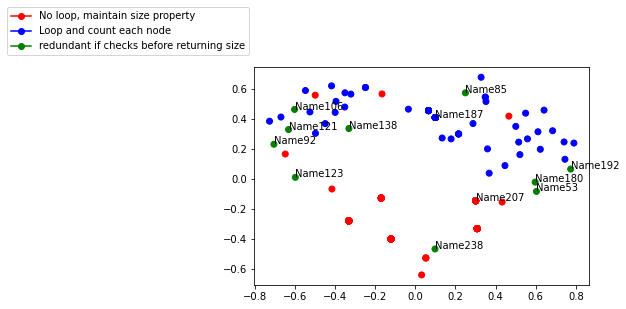

In [12]:
fig, ax = plt.subplots()
manual_rare_label=[s['label'] for s in methods]
cmap={'1':'red','2':'blue', '3':'green','4':'yellow'}
ax.scatter(jaccard_vectors_2dim[:,0],jaccard_vectors_2dim[:,1], c=[cmap[i] for i in manual_rare_label])
custom_legend=(Line2D([0],[0], marker ='o',color='red'),Line2D([0],[0], marker ='o',color='blue'), Line2D([0],[0], marker ='o',color='green'))
ax.legend(custom_legend,["No loop, maintain size property","Loop and count each node","redundant if checks before returning size"],bbox_to_anchor =(0,1.3))
for i in range(jaccard_vectors_2dim.shape[0]):
    if(manual_rare_label[i]=='3'):
        ax.annotate(methods[i]['studentID'], (jaccard_vectors_2dim[i,0],jaccard_vectors_2dim[i,1]))

In [13]:
jaccard_vectors_30dim = MDS(n_components=30, dissimilarity='precomputed',max_iter=10000).fit_transform(sim_mat_jaccard)
kmeans = KMeans(n_clusters=3,max_iter=10000)
kmeans.fit(jaccard_vectors_30dim)
labels_med = kmeans.labels_


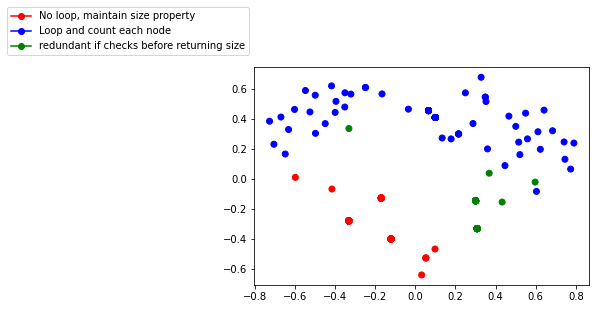

In [16]:
from matplotlib.lines import Line2D
fig, ax = plt.subplots()
#empty_label=[m['label'] for m in load_json(path+'isEmpty_Jaccard_2Groups.json')]
cmap1={'1':'red','0':'blue', '2':'green','3':'yellow'}
ax.scatter(jaccard_vectors_2dim[:,0],jaccard_vectors_2dim[:,1], c=[cmap1[str(i)] for i in labels_med])
custom_legend=(Line2D([0],[0], marker ='o',color='red'),Line2D([0],[0], marker ='o',color='blue'), Line2D([0],[0], marker ='o',color='green'))
ax.legend(custom_legend,["No loop, maintain size property","Loop and count each node","redundant if checks before returning size"],bbox_to_anchor =(0,1.3))

In [17]:
for i,m in enumerate(methods):
    m['label']=str(labels_med[i])
save_json(methods,path+'size_Jaccard_2Groups-2.json')

*********************************

iou:{('1', '1'): 0.6503496503496503, ('0', '2'): 0.8762886597938144, ('2', '1'): 0.30344827586206896}


accuracy:{('1', '1'): 0.6595744680851063, ('0', '2'): 0.9883720930232558, ('2', '1'): 0.3120567375886525}

rand score: 0.7857318659681446
adjusted rand score: 0.5659681310921011
normalized mutual information: 0.5820771357128927
fowlkes mallows score: 0.7512626791830764
confusion matrix:
    (0,0) - True Negatives. Pair is not clustered together in the predicted and manual clustering.
    (0,1) - False Positives. Pair is clustered together in prediction but not manual clustering.
    (1,0) - False Negatives. Pair is not clustered together in prediction but is clustered together in manual clustering.
    (1,1) - True Positives.  Pair is clustered together in the predicted and manual clustering.



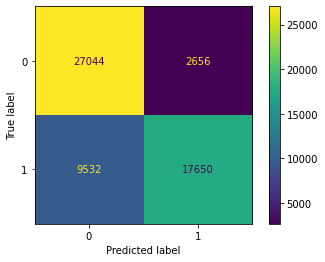

In [18]:
dict_size ={s['studentID']:s for s in load_json(path+'size_Jaccard_2Groups-2.json')}
save_json(dict_size,path+'/size_Jaccard_2Groups-2.json')
compare(path+'size_Jaccard_2Groups-2.json',path+'/sizeDict.json','label').plot()

In [107]:
a='2'
b='3'
x= set([s[0] for s in list(filter(lambda x: x[1]['label']=='3', load_json(path+'size_Jaccard_2GroupsDict.json').items()))])
y= set([s[0] for s in list(filter(lambda x: x[1]['label']=='1',load_json(path+'/sizeDict.json').items()))])


In [108]:
len(x.intersection(y))/(len(x.union(y)))

0.0

In [109]:
len(x.intersection(y))/(len(y))

0.0

In [5]:
y=load_json(path+'/sizeDict.json')
jaccardStringSimilarity(y['Name100']['description'], y['Name238']['description'])

{'queue', 'size', 'is', 'returning', 'of'} {'return', 'if', '0', 'size', 'headcell', 'list', 'is', 'returning', 'of'}


0.6